In [20]:
import os
import sys
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from Bio import SeqIO
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier


#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())

1336038


1. Define data set specific values

In [21]:
k=15
NAME_DICT = {0:"human", 1:"bat"}

2. Import counts, separate features and labels

In [22]:
counts = pd.read_csv(f"../output/bat/{k}mer_counts_for_classifier.csv", index_col=0)
kmer_group = counts.loc[['group', 'exclusivity']].drop('host', axis=1)
counts.drop(['group', 'exclusivity'], inplace=True)
X = counts.drop('host',axis=1).astype(float)
y = counts['host'].astype(float)

/tmp/ipykernel_1336038/1690857459.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,2

3. Calculate k-mer count correlation and select only linearily independant k-mers. This may take a long time, depending on the number of initial k-mers.

In [5]:
#Calculate k-mer count correlation matrix
X_corr = X.corr()
print("Done calculating k-mer count corrrelation.")

#Construct a graph where nodes represent k-mers and edges connect k-mers with count correlation coefficient of more than 0.9 
features_list = list(X_corr.columns)
edge_list = set()
for i in range(1,len(features_list)):
    print(i, end='\r',flush=True)
    k1 = features_list[i]
    for j in range(i):
        k2 = features_list[j]
        if abs(X_corr.loc[k1,k2] > 0.9):
            edge = (k1,k2)
            edge_list.add(edge)
corr_graph = nx.Graph(edge_list)
del edge_list
print("Done constructing correlation graph.")

#Calculate count correlation with host label for each k-mer
y_corr_dict={}
y_corr_abs_dict={}
for kmer in corr_graph.nodes:
    y_corr = X[kmer].corr(y)
    y_corr_abs = abs(y_corr)
    y_corr_dict[kmer] = y_corr
    y_corr_abs_dict[kmer] = y_corr_abs
nx.set_node_attributes(corr_graph, y_corr_dict,"y_corr")
nx.set_node_attributes(corr_graph, y_corr_abs_dict,"y_corr_abs")

#Seperate correlated k-mer groups
corr_groups = [corr_graph.subgraph(c).copy() for c in nx.connected_components(corr_graph)]

#List k-mer missing from the graph, i.e. not correlated with any other k-mer
indep_kmers = [kmer for kmer in features_list if kmer not in corr_graph.nodes]
print(f"There are {len(corr_groups)} groups of k-mers with highly correlated counts.")
#For large k-mers sets, you may want to delete the graph to save memory. Uncomment the following line.
# del corr_graph

#From each group of correlated k-mers select the one with the highest correlation of counts with host labels and add to the list of independent k-mers.
for group in corr_groups:
    y_corr_abs = nx.get_node_attributes(group,"y_corr_abs")
    indep_kmers.append(max(y_corr_abs, key=lambda x: y_corr_abs[x]))
del corr_groups

#Extract the count matrix of independent k-mers from the count matrix of all enriched k-mers
X_indep = X.loc[:,indep_kmers]
print(f"{len(X_indep.columns)} linearily independent k-mers selected.")

Done calculating k-mer count corrrelation.
Done constructing correlation graph.
There are 33 groups of k-mers with highly correlated counts.
39 linearily independent k-mers selected.


In [6]:
#Uncomment the following lines as needed to save/load the independent k-mers count matrix and avoid re-calculation of correlation.

X_indep.to_csv(f"../output/bat/{k}mer_indep_counts.csv") 
# X_indep = pd.read_csv(f"../output/bat/{k}mer_indep_counts.csv", index_col=0)

Optional: plot k-mer counts correlation clustermap and graph. WARNING: make take a long time and a lot of memory, especially for large k-mer sets!

/home/labadmin/repos/PORT-EK 2/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/labadmin/repos/PORT-EK 2/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


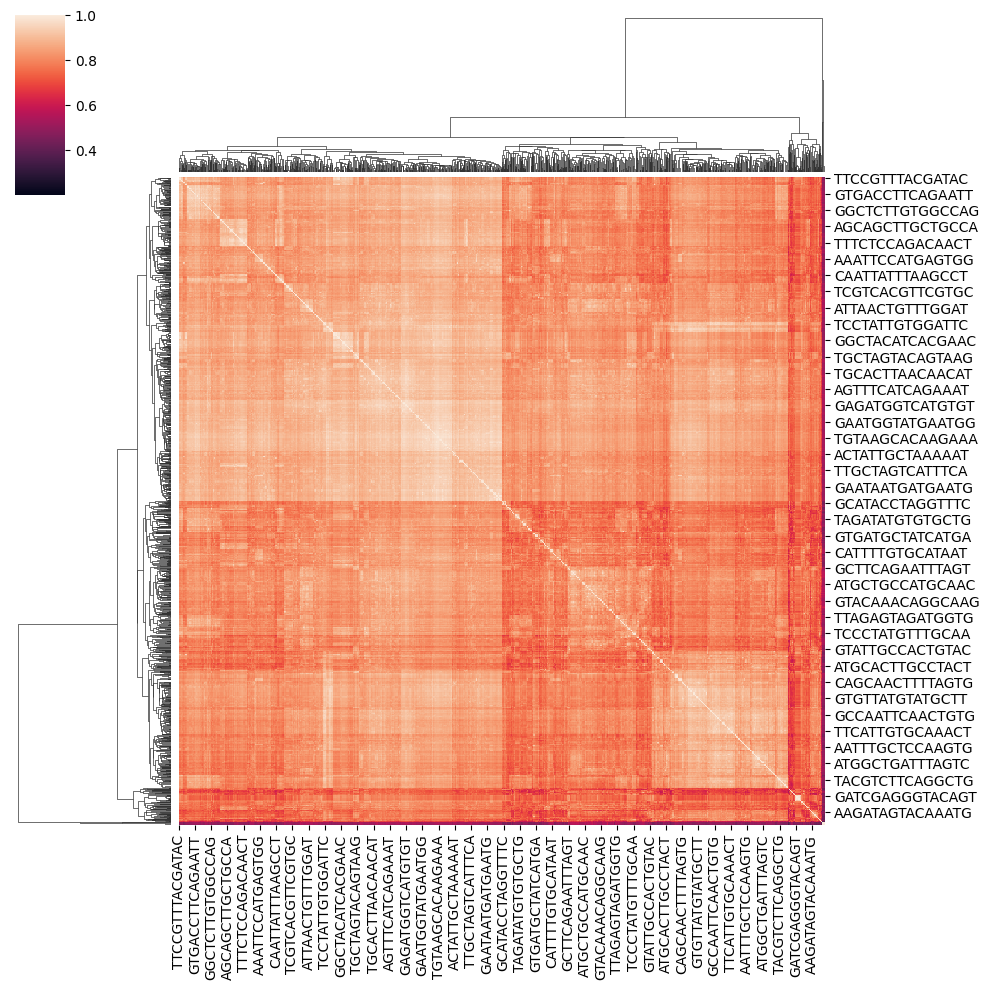

In [7]:
sns.clustermap(X_corr)

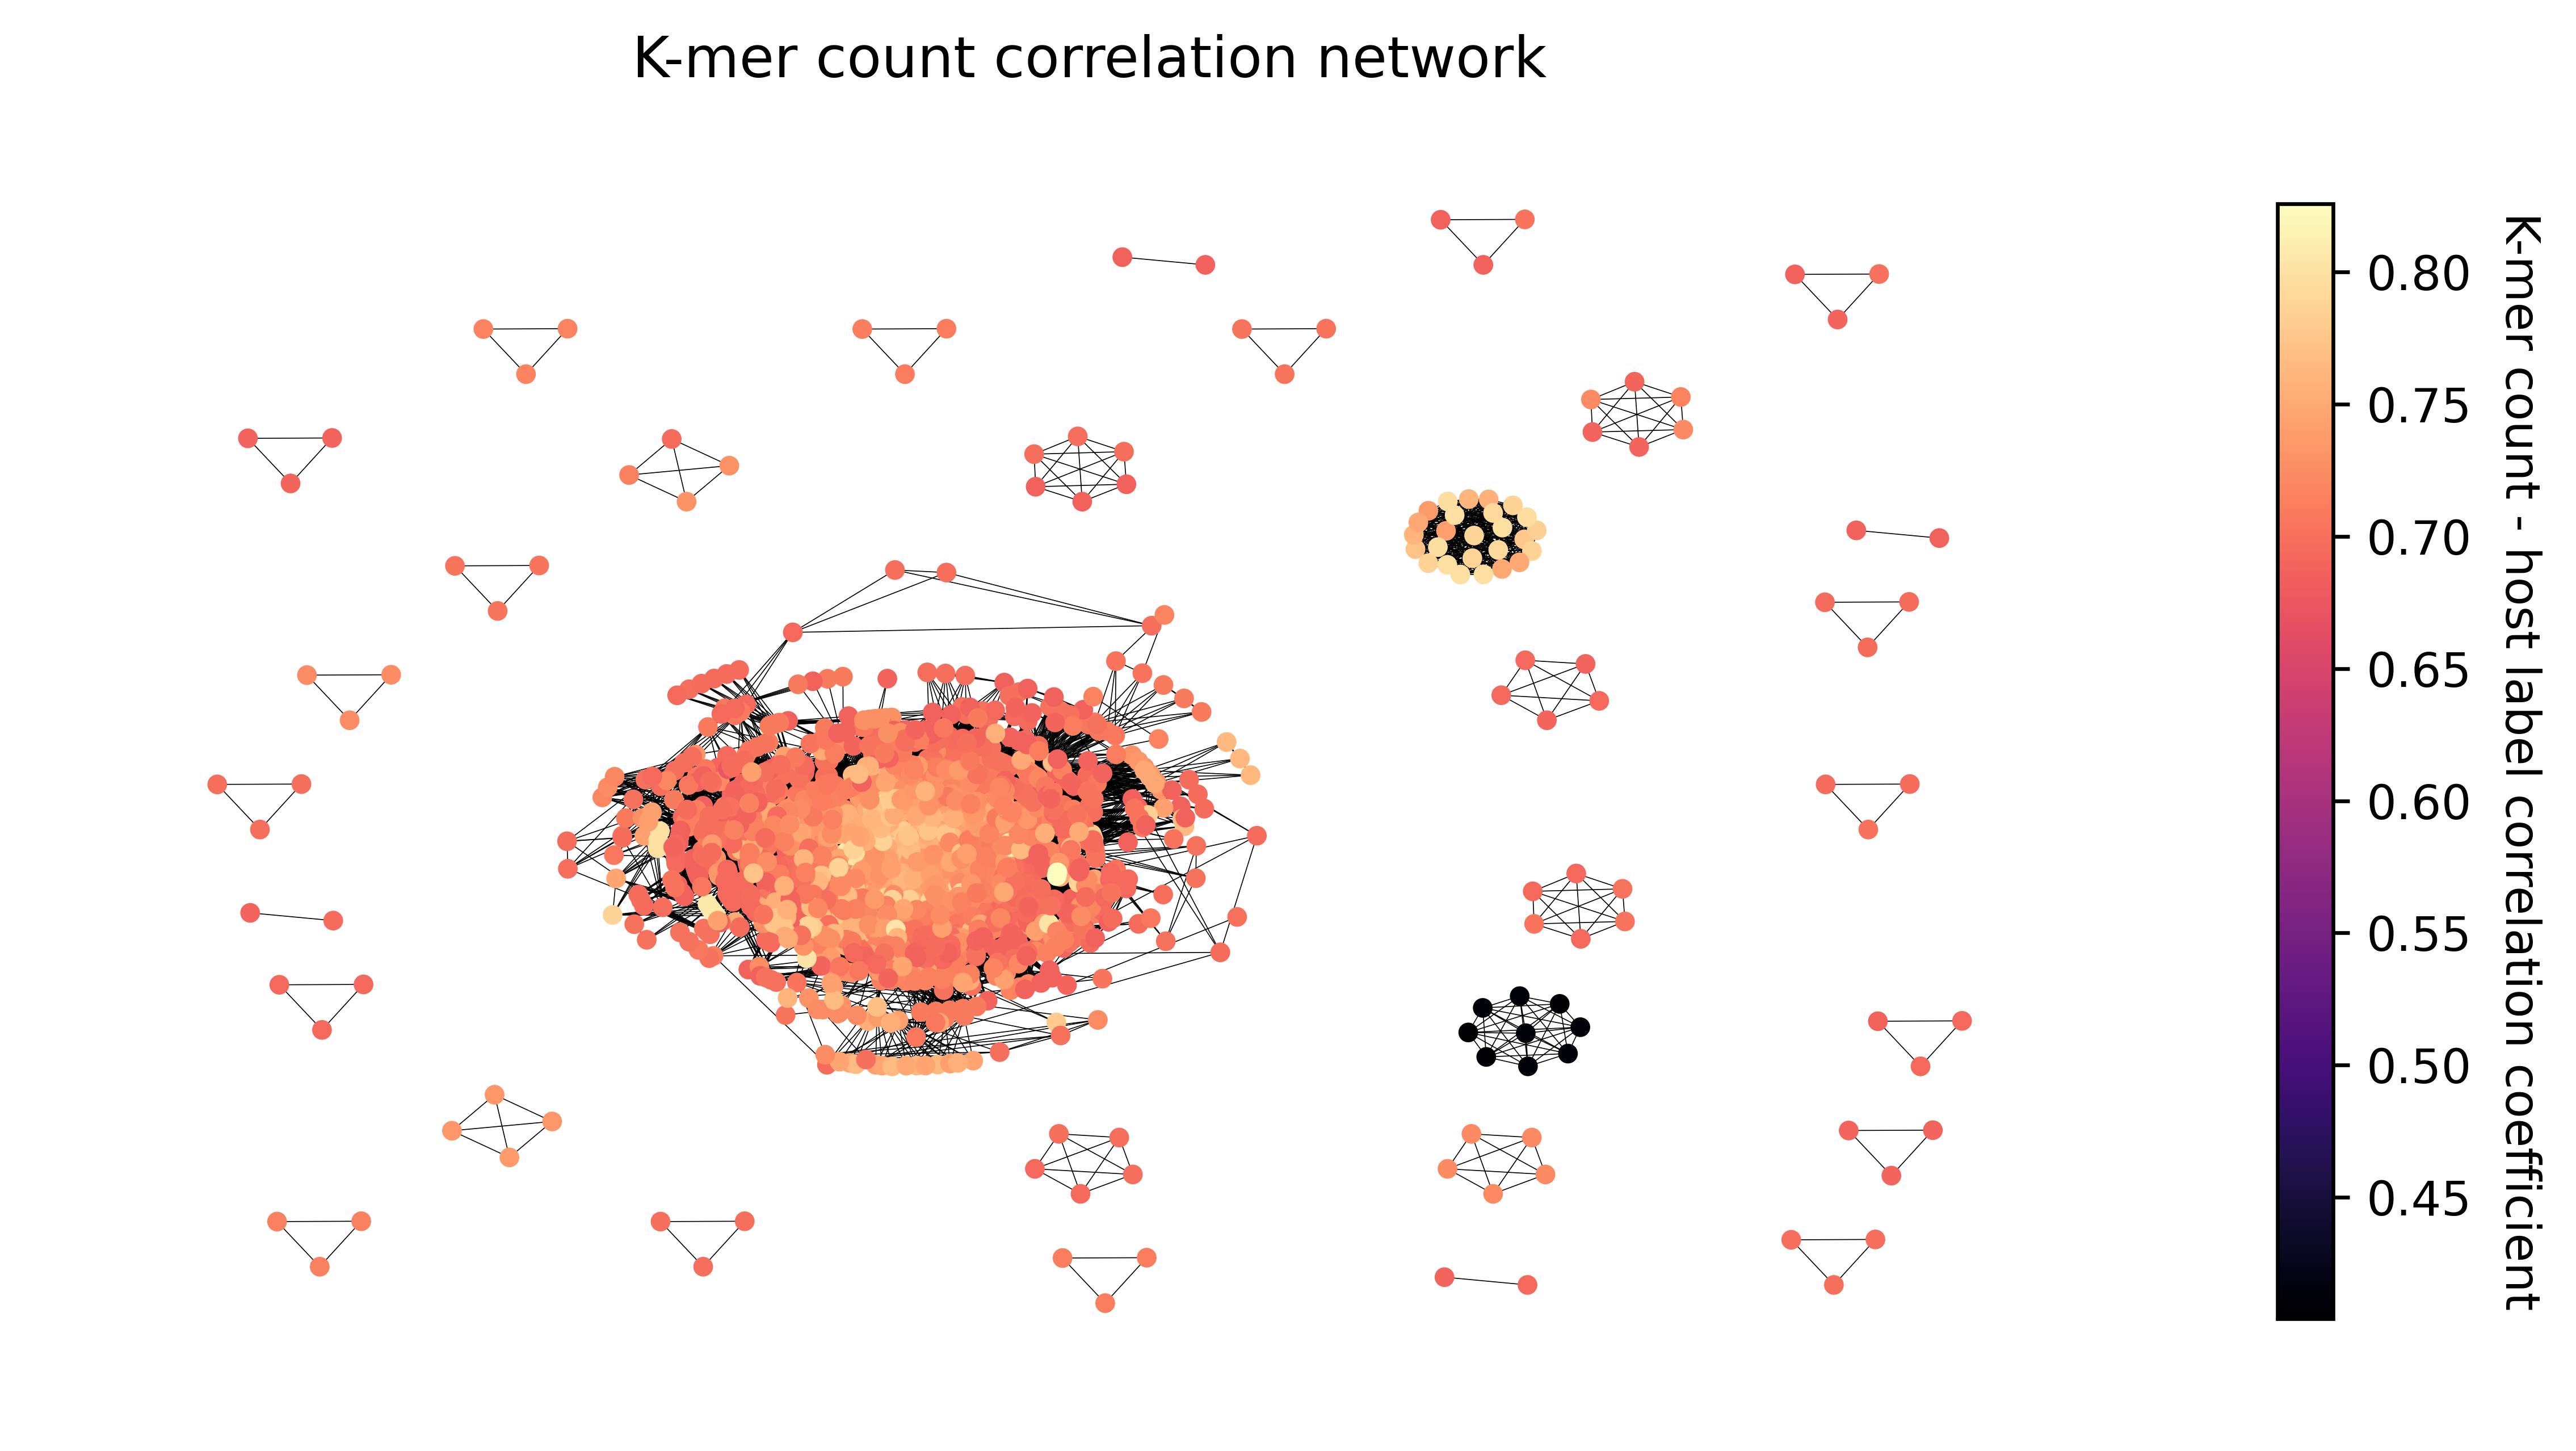

In [8]:
fig, ax = plt.subplots()
corr_pos = nx.nx_agraph.graphviz_layout(corr_graph, prog="neato")
colors = [corr_graph.nodes[node]["y_corr"] for node in list(corr_graph.nodes())]
nx.draw(corr_graph, pos=corr_pos, node_size=10, node_color=colors, cmap='magma', with_labels=False, width=0.2)
fig.set_size_inches(10,5)
fig.set_dpi(600)
ax.set_title("K-mer count correlation network")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="magma", norm=plt.Normalize(min(colors),max(colors))), ax=ax, shrink = 0.85)
cbar.set_label("K-mer count - host label correlation coefficient", rotation=270, labelpad=15)
plt.show()
del corr_graph

4. Calculate k-mer importances acording to MDI and premutation importance, using a random forest classifier.

In [23]:
#Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=14)

In [24]:
#perform classification using a simple random forest
rf_imp= RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=14)
rf_imp.fit(X_train,y_train)
y_pred = rf_imp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       625
         1.0       0.96      1.00      0.98        79

    accuracy                           1.00       704
   macro avg       0.98      1.00      0.99       704
weighted avg       1.00      1.00      1.00       704



In [25]:
imps = pd.DataFrame({'name':rf_imp.feature_names_in_,'importance':rf_imp.feature_importances_}).set_index('name')
perm_imps= permutation_importance(rf_imp, X_test, y_test, scoring='f1_weighted', random_state=14)
perm_importances = pd.DataFrame(perm_imps['importances_mean'], index=X_test.columns, columns=['perm_importance'])
com_imp = pd.concat([imps, perm_importances], axis=1).sort_values('importance', ascending=False)

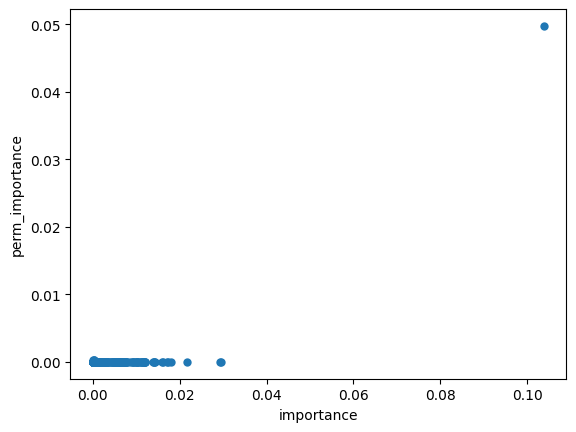

In [26]:
#Plot permutation and MDI importance
fig,ax=plt.subplots()
sns.scatterplot(data = com_imp,x="importance", y="perm_importance", linewidth = 0)
plt.show()
#Uncomment the following line to save the plot as svg.

In [27]:
#Discard unimportant k-mers and redo train/test split.
imp_kmers = com_imp[(com_imp['importance'] > 0) | (com_imp["perm_importance"]>0)].index
print(f"{len(imp_kmers)} k-mers selected after importance filter.")
X_imp = X_indep.loc[:,imp_kmers]
X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp,y, test_size=0.3, stratify=y, random_state=14)

406 k-mers selected after importance filter.


KeyError: "['GGTTTTGCAAAGTTC', 'AAACATGGTGGTGGT', 'CAGGATGGCAATGCT', 'AAACTGTTTACAGTG', 'TGCTCGCAAACATAG', 'CAGGCTATGACCCAA', 'AACGACAATATTGCT', 'TGTTTTGGAACTGTA', 'ATGTGGCTTAGCTAC', 'TAAAAACTGTTTACA', 'AATGGTCAGGTTTTT', 'ACAATCGACGGCTCT', 'CAACGACAATATTGC', 'TGCAAAGTTCCTAAA', 'GCTTGGCCTCTTATT', 'TTGCAAAGTTCCTAA', 'GGCTAAATCTGAGTT', 'TAAACGAACTAACTA', 'ATCTGAGTTTGACCG', 'TGGTTTTGCAAAGTT', 'AGGCTATGACCCAAA', 'GTTAAACAAGGAGAT', 'ATGGTCAGGTTTTTG', 'GACTTTTATGACTTT', 'TTGTTAACGTGAGTT', 'AGGATGGCAATGCTG', 'TTGTTTTGGAACTGT', 'TGTTTACAGTGATGT', 'GAAGGATTGGTATGA', 'AGACAGTTTCATCAG', 'TTTGCAAAGTTCCTA', 'AACAAGTACAAGTAT', 'ACAAGTACAAGTATT', 'CACAATCGACGGCTC', 'TACGATCGAGGGTAC', 'TGTGGCTTAGCTACT', 'TGTGTGCTAATGGTC', 'GGTACAGTGAATAAT', 'TGCTAGTACAGTAAG', 'AGAAAATGTGGCTTA', 'AGCTGCTACAGTACG', 'AGTACGATCGAGGGT', 'CTGTTTACAGTGATG', 'TATTGATTGTAATGC', 'AACTGTTTACAGTGA', 'AACTTTAACATTGCT', 'GAAAACAATAGGTCC', 'GTAGCAACGACAATA', 'GAGGGTACAGTGAAT', 'GTGAGATGGTCATGT', 'TTTTGCAAAGTTCCT', 'TTTGCTCAGGATGGC', 'CTCAGGATGGCAATG', 'TCTTTTGTTATGATG', 'ATACACACAATCGAC', 'CTGGCTATGTTGACA', 'ATGATGATTTCTGCT', 'GGCTTTTGATATTTA', 'AAAACTGTTTACAGT', 'AAGTGGAGGACAACC', 'TGAAAACAATAGGTC', 'TAAGTGAGATGGTCA', 'GAGTTTAGTAAAACC', 'CTGGTTTTGCAAAGT', 'TAAACAAGGAGATGA', 'AATAGTAAAGTACAG', 'CGACAATATTGCTTT', 'GATCGAGGGTACAGT', 'TTGCTGGTTTTGCAA', 'CCTATGTTTGCAATG', 'CTTTTATGACTTTGC', 'CCGACGAGTTCGTGG', 'TCTGTTAATCCCTAT', 'ATTGTAGATGCCACA', 'GATAATGATGCACTT', 'GTTTTGCAAAGTTCC', 'GGATGGCAATGCTGC', 'TGGAGGACAACCAAT', 'GTGTGCTAATGGTCA', 'CTTGGCCTCTTATTG', 'TGATGACAATGCACT', 'AAACGAACATGAAAC', 'TATTGTAGATGCCAC', 'ATGTTCATATTATGG', 'GACAGTTTCATCAGA', 'ACAGTTTCATCAGAA', 'TGATTATGACTATTA', 'TTGCTCAGGATGGCA', 'ATGGCAATGCTGCTA', 'TACTACCCATCTGCT', 'TGGTGATTACTTTGT', 'ACTGTTTACAGTGAT', 'AGGACAAAAAGAAAA', 'AGGGTACAGTGAATA', 'TACCTACCACTTGTG', 'GTTGGTGATTACTTT', 'CTTTGTGCTTGCTGC', 'CAACGTTTTTAAACG', 'ACGAACATGAAACTT', 'CTCTCACTCAGCATG', 'AGAAATTCAACTCCT', 'TTGCCACTGTACGTG', 'GCTTTGTGCTTGCTG', 'TTGTGTGCTAATGGT', 'CGAGGGTACAGTGAA', 'GCTTTGTTGCATGAC', 'CTACATGCCTGCTAG', 'TGGCAATGCTGCTAT', 'CAGTGAATAATGCTA', 'TGCTGTGTCTAAAGG', 'ATAAGAAGGATTGGT', 'TGCTTTGTGCTTGCT', 'ATGACCCAAATGTAC', 'GCATTCTTCGGAATG', 'AAAGATCCACAATTC', 'TATGGTATTGCCACT', 'GTGGAGGACAACCAA', 'TGACTTTTTCAAGTT', 'GCTAGTTGTGATGCT', 'CGTTTACGATACATA', 'TGACCCAAATGTACA', 'GTAGACTCATCTCTA', 'GACTTTTTCAAGTTT', 'TACCATCCCAATTGT', 'GTACAGTGAATAATG', 'CAATCGACGGCTCTT', 'TCGAGGGTACAGTGA', 'CATGACTTTTTCAAG', 'ACACAATCGACGGCT', 'GTCTGTTAATCCCTA', 'AATGACTGACATTGC', 'TGTCTGTTAATCCCT', 'AACGTTTTTAAACGG', 'CTAAACGAACTAACT', 'TTGCTGTGTCTAAAG', 'ATGACTTTTTCAAGT', 'CAAGTGGAGGACAAC', 'TTTGCTGTGTCTAAA', 'TAATAAGTTCAATAG', 'ACGATCGAGGGTACA', 'AAAAACTGTTTACAG', 'TGCTAGTTAAACAAG', 'GCTTGCTTTGTGCTT', 'GGTGATTACTTTGTG', 'GCTCTCACTCAGCAT', 'CACAATTCAAAGACA', 'GCATTCTTGGAATGC', 'TTAAGGACTGTAGTA', 'AAGAAGGATTGGTAT', 'CCTAGGTTTCGTCCG', 'TTACATTTGGTGGAC', 'AGCATACCTAGGTTT', 'TTCTGGCAATTTATT', 'TACCTAGGTTTCGTC', 'ATTGCCACTGTACGT', 'ATCATCAGCATACCT', 'CTAGTTGTGATGCTA', 'TAGTTGTGATGCTAT', 'TCTACTACCCATCTG', 'TCCACAATTCAAAGA', 'AGAAGGATTGGTATG', 'TTTCAAGAAAGGTGC', 'ATGCTAGTTAAACAA', 'GGAGTACGATCGAGG', 'GCTAGTTAAACAAGG', 'ACGATACATAGTCTA', 'CCTATGTGTTCATTA', 'AGTGCTTTAGTTTAT', 'TGCCACTGTACGTGA', 'TGCTTGCTTTGTGCT', 'GTATTCTTGCTAGTC', 'GATGGCAATGCTGCT', 'ACATGGTGGTGGTGT', 'ACTTTTTCAAGTTTA', 'GTCTACATGCCTGCT', 'GCAATGCTGCTATCA', 'TGGTGTTTATGACTA', 'TGCTTTGTTGCATGA', 'CTTGCCTACTATAAC', 'GCTATTTCCATGTGG', 'TTGCTTGCTTTGTGC', 'CTTGCTTTGTGCTTG', 'GACTATTATCGTTAT', 'TTGGTGATTACTTTG', 'GCTACTGTACAGTCT', 'TAAACATCTTATACC', 'TAAGGACTGTAGTAA', 'GCCACTGTACGTGAA', 'TAAGAAGGATTGGTA', 'GCAAAGTTCCTAAAA', 'TTTAAGGACTGTAGT', 'GTGAATAATGCTAGG', 'TAGTGTTGTCTGTTA', 'TCTAAACGAACTAAC', 'TCTAAACGAACATGA', 'TGCTTTAGTTTATGA', 'TTCTTGCTAGTCACA', 'CTACCAAATTGGTGG', 'TACTGATGACAATGC', 'CTACTACCCATCTGC', 'TTTCTGGTAAAGGCC', 'CATTACATTTGGTGG', 'GGGAAATTCTCCTGC', 'TCAGGATGGCAATGC', 'AGTAGGGGAAATTCT', 'CTGCATTCTTCGGAA', 'CTATTATCGTTATAA', 'TGACTATTATCGTTA', 'TTCTGGTAAAGGCCA', 'GCTAGTCACACTAGC', 'ACTATTATCGTTATA', 'GTGCTTTAGTTTATG', 'GGCAATGCTGCTATC', 'CTCTACTACCCATCT', 'ATGGTATTGCCACTG', 'TGCTCAGGATGGCAA', 'AAAGTACAGATTGGA', 'GAAACTCGACTCCGC', 'CAAAGATCCACAATT', 'GACCCAAATGTACAA', 'ACTCCGCAAGGGAGG', 'TATTCTTGCTAGTCA', 'GTATTGCCACTGTAC', 'TATTGCCACTGTACG', 'CAACTTTTGATGCTG', 'GGTGTATCCTTCATT', 'ATATCAGACAACTCC', 'TACAGGGCTTTTGAT', 'ATGACTATTATCGTT', 'TATGACTATTATCGT', 'GTGATTATGACTATT', 'TCCCTATGTTTGCAA', 'TGCACAATTTGCTCC', 'TGGTATTGCCACTGT', 'TTATGACTATTATCG', 'TAGCTGCTACAGTAC', 'TTAAAAACTGTTTAC', 'TGGTGAAAATGCTGT', 'AAGGTCGGTATGCAA', 'TCAGACAACTCCTAT', 'TGGTGGACAGCTTTT', 'TCAATGGAGTCACAT', 'GATTATGACTATTAT', 'AATGTACAAACAGGC', 'ACACACAATCGACGG', 'TGGGCTATGTAAACG', 'TATCAGACAACTCCT', 'TCTGCATTCTTCGGA', 'GCTAGTACAGTAAGT', 'GCGTAATGTCATCCC', 'ACAAAGATCCACAAT', 'TCTACATGCCTGCTA', 'GAGTTGTACATAATC', 'TAGAACAGTATGTTT', 'AGAACAGTATGTTTT', 'GATCATGTTGACATA', 'AAAAATCTGAACTCT', 'AGATCATGTTGACAT', 'AAGATCATGTTGACA', 'CTTTACCGCAGAGAC', 'TATTAAGTGGGATTT', 'ACAAGATCATGTTGA', 'CAAGATCATGTTGAC', 'CACAAGATCATGTTG', 'ACACAAGATCATGTT', 'TTCAGGTTTTGCTGC', 'AGCACTACGACAGAT', 'CACAGGCACTAGCAC', 'GACTTAGGTGACGAG', 'GTAGCACTACGACAG', 'TGATTCAGGTTTTGC', 'ATTCAGGTTTTGCTG', 'ACTTAGGTGACGAGC', 'TGACTTAGGTGACGA', 'CTAGCACTGATGTCG', 'GGCTTGATGTGGCTT', 'TAGCACTACGACAGA', 'CTTAGGTGACGAGCT', 'TTAGGTGACGAGCTT', 'GATGTGGCTTAGCTA', 'ACAGGCACTAGCACT', 'CACTAGCACTGATGT', 'ACTAGCACTGATGTC', 'GCACTAGCACTGATG', 'CTTGATGTGGCTTAG', 'TAGCACTGATGTCGT', 'GGCACAGGCACTAGC', 'GGCACTAGCACTGAT', 'GCTTGATGTGGCTTA', 'AGGCACTAGCACTGA', 'GCACAGGCACTAGCA', 'AACTAATTGCTGCCG', 'CAGGCACTAGCACTG', 'TGATGTGGCTTAGCT', 'GTGGCTTAGCTACTT', 'ACAGCTTGTACTGAT', 'TGGCTTAGCTACTTC', 'TTGATGTGGCTTAGC', 'AAATAGTAAAGTACA', 'TGAGACAATTATTTA', 'TGACAATGCACTTGC', 'GGCTATGTAAACGTT', 'CGTCTTGGTTCACAG', 'TAGCAGAGATATTGA', 'TAAAGTCTTATGACT', 'GAATGGTCGTACTAT', 'AATCGACGGCTCTTC', 'GATGATTCTTTCTGA', 'GATTTTATCCCTATG', 'AGTACGTCTTCAGGC', 'TGCTGTTGTGTACAG', 'GAAGTTCTGTTGAAC', 'TCAAGTTTAGAGTAG', 'ACTGGCTATGTTGAC', 'ACTGAGAGTGCTTGT', 'AACCTATGTAACACA', 'TCATGATGACCACAC', 'CAGGTTACAATAGCA', 'ATTCTTCGGAATGTC', 'TTCTCCATGATGATT', 'TCTTCGGAATGTCAC', 'TGTCAAACTACAGAA', 'CTTACACAGAGATTG', 'CTAAAAATAGTAAAG', 'GCACTTAACAACATT', 'GTAGGCAATGTCATA', 'GTCTTGGTTCACAGC', 'GCAAATACACACAAT', 'TTTCAAGTTTAGAGT', 'TGAGTTTGACCGTGA', 'ACAAATTAGGAGCGT', 'GCAAGTTGTTGATGC', 'CTGCCAACAATGTGT', 'CAGTGATGTAGAAAC', 'TGAATGGTCGTACTA', 'CCTCTGAAGAAGTAG', 'CCACTGTACGTGAAG', 'ACCTTCTCTTGCAAC', 'CTTATGACTTAGGTG', 'GTGTTGAGTATTACC', 'AGATCCACAATTCAA', 'GACTCCGCAAGGGAG', 'CAATGCTGCTATCAG', 'CAGCAACTTTTAGTG', 'CCAGGCTGCGGAGTT', 'ATGCTGTTGTGTACA', 'AATGTGTAACATTAG', 'TTGACATACCAGGCA', 'TGTTATGTATGCTTC', 'CTAGGAACTGGCCCA', 'AGCTTGATAATGATG', 'GTAAAGTACAGATTG', 'CAATTGTCTTCCTAT', 'TTGTGCGAGGAAATG', 'AACTGGCCCAGAAGC', 'GATGCACTTAACAAC', 'CAGCAGTGGGGTTTT', 'CATGATGATTCTTTC', 'TGGATGAATTCATAC', 'TGGCTGACTTATCAT', 'AAGAACGTGTTGTCT', 'TTTAGTAAAACCAAC', 'AAAATTCCATGAGTG', 'AGTTAAAGAAATCTT', 'CGATCATCAGCATAC', 'TTCCATGAGTGGAGC', 'CAATTTGCTCCAAGT', 'CACTCATGATGACCA', 'CATCTTTCATGGGAG', 'ACAGAGCCATGCCTA', 'TTCTGATGATGCCGT', 'AGGTTAGAGACGTGC', 'AATTGTATTAACTGT', 'TGTGCCATGAGACCT', 'CTTGATAATGATGCA', 'AAATGCGAGTTTTGA', 'CTGTGATCATTCGTG', 'AGTTCAATAGTGAGA', 'TTGCTGCCACTTAGC', 'GGGCTTTTGATATTT', 'GCCAGAGATTAAGAT', 'AATAATGAACTGAGT', 'AAAAATAGTGTTAAG', 'AAATTCACTGATGGT', 'GAAGGCATCGTATGG', 'TCTGCCAACAATGTG', 'CTTTAATCAATGTGT', 'GAGTACGATCGAGGG', 'CAAAAGTAACTAGTG', 'GCCCTCGCGCTATTG', 'TTGCTAGTCACACTA', 'TCTTATTACAAATTA'] not in index"

5. Classify the samples according to most probable host using various model architectures.

In [ ]:
#Calculate class weights
CLASS_WIEGHTS = {}
for class_label in NAME_DICT.keys():
    class_weight = len(y_train)/len(y_train[y_train == class_label])
    CLASS_WIEGHTS[class_label] = class_weight
print(CLASS_WIEGHTS)

#Set up and build neural-network
keras.utils.set_random_seed(14)
N_KMERS = len(X_imp.columns)
HIDDEN_DIMS = [1024,256]
N_LABELS = len(CLASS_WIEGHTS)
if N_LABELS > 2:
    y_train = OneHotEncoder(sparse_output=False).fit_transform(pd.DataFrame(y_train))
    N_OUTPUT = N_LABELS
    OUTPUT_ACTIVATION = "softmax"
    LOSS = "categorical_crossentropy"
else:
    N_OUTPUT=1
    OUTPUT_ACTIVATION = "sigmoid"
    LOSS = "binary_crossentropy"
DROPOUT = 0.3
LEARNING_RATE = 1e-5
N_EPOCHS = 50
BATCH_SIZE = 8

metrics = ['accuracy', keras.metrics.AUC()]
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=3)
classification_optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

def build_nn(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_shape,)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(units=HIDDEN_DIMS[0],activation='gelu', kernel_constraint=keras.constraints.MaxNorm(3)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(units=HIDDEN_DIMS[1],activation='gelu', kernel_constraint=keras.constraints.MaxNorm(3)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(units=N_OUTPUT,activation=OUTPUT_ACTIVATION))
    model.compile(loss=LOSS, optimizer = classification_optimizer, metrics=['accuracy'])
    return model

model_nn = build_nn(N_KMERS)

{0: 1.1263736263736264, 1: 8.91304347826087}


2024-08-28 10:21:56.949230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 10:21:56.982326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 10:21:56.982438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
#Train and test neural network
model_nn.fit(X_imp_train,y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, class_weight=CLASS_WIEGHTS, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/50


I0000 00:00:1724833317.637601 1402321 service.cc:145] XLA service 0x72c7c8008190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724833317.637624 1402321 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-28 10:21:57.653723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 10:21:57.738780: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 94/185 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.7259 - loss: 1.4216

I0000 00:00:1724833319.369177 1402321 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7651 - loss: 1.3757 - val_accuracy: 0.9817 - val_loss: 0.6494
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.9592 - loss: 1.1681 - val_accuracy: 0.9817 - val_loss: 0.6187
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.9702 - loss: 1.0209 - val_accuracy: 0.9817 - val_loss: 0.5872
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.9757 - loss: 0.9397 - val_accuracy: 0.9756 - val_loss: 0.5549
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.9743 - loss: 0.8654 - val_accuracy: 0.9756 - val_loss: 0.5174
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.9717 - loss: 0.7953 - val_accuracy: 0.9756 - val_loss: 0.4777
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.9803 - loss: 0.7597 - val_accuracy: 0.9756 - val_loss: 0.4392
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.9820 - loss: 0.6925 - val_accuracy

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       625
         1.0       1.00      0.78      0.88        79

    accuracy                           0.98       704
   macro avg       0.99      0.89      0.93       704
weighted avg       0.98      0.98      0.97       704



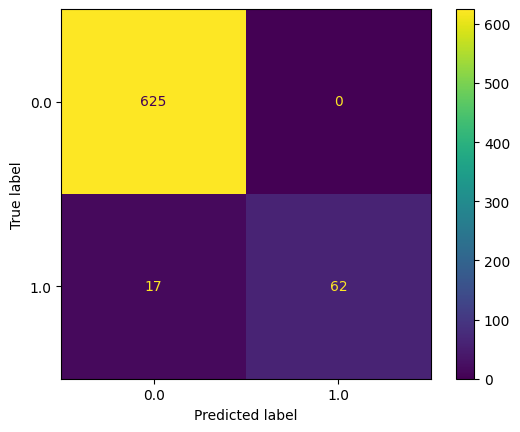

In [ ]:
y_score = model_nn.predict(X_imp_test)
y_pred = y_score>0.5
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

7. Bootstrapping

In [ ]:
# Train the neural network on 100 diffrent train/test splits and evaluate (also on OoB data). 
#This helps check if the performance is not an artifact of thje previous train/test split.

f1s = []
f1s_oob = []
for i in range(10):
    X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp,y, test_size=0.3, stratify=y, random_state=i)
    if len(CLASS_WIEGHTS) >2:
        y_train = OneHotEncoder(sparse_output=False).fit_transform(pd.DataFrame(y_train))
    classification_optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)
    model_nn_bs = build_nn(N_KMERS)
    model_nn_bs.fit(X_imp_train,y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, class_weight=CLASS_WIEGHTS, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_score = model_nn_bs.predict(X_imp_test, verbose=0)
    y_pred = y_score > 0.5
    f1s.append(f1_score(y_test, y_pred, average="weighted"))
    print(i, end="\r")

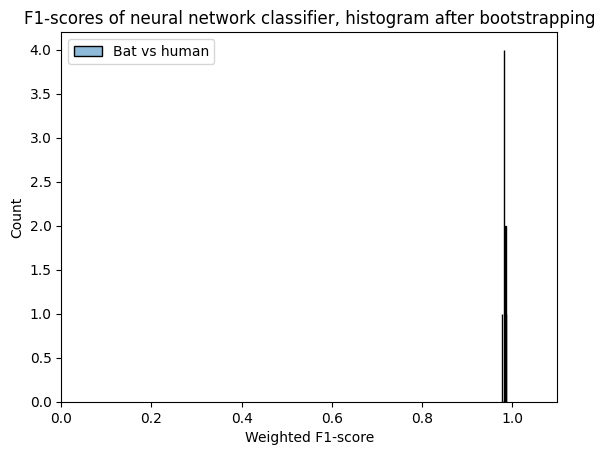

In [ ]:
#Plot histograms of f1-scores
fig, ax = plt.subplots()
f1s_df = pd.DataFrame({"Bat vs human": f1s})
sns.histplot(f1s_df, bins=20)
ax.set_title("F1-scores of neural network classifier, histogram after bootstrapping")
ax.set_xlim(0,1.1)
ax.set_xlabel("Weighted F1-score")
plt.show()

#Uncomment the following line to save the plot as svg.
fig.savefig("../output/bat/nn_bootstrap.svg", dpi=600, format="svg")

In [ ]:
np.median(f1s)

0.9830968144762489